In [3]:
import re
import pandas as pd
from collections import defaultdict

# Function to extract data from the structure info file and group by space group
def extract_structure_data(file_path, functional_name, grouped_data):
    with open(file_path, 'r') as file:
        data = file.read()
    
    # Split data by separators
    phases = data.split('-----------------------------------------')
    
    for phase in phases:
        # Extract space group, lattice constants, and angles
        space_group_match = re.search(r'International:\s*(\S+)', phase)
        lattice_constants_match = re.search(r'Lattice Constants:\s*([\d\.]+\s+[\d\.]+\s+[\d\.]+)', phase)
        lattice_angles_match = re.search(r'Lattice Angles:\s*([\d\.]+\s+[\d\.]+\s+[\d\.]+)', phase)
        
        if space_group_match and lattice_constants_match and lattice_angles_match:
            space_group = space_group_match.group(1)
            lattice_constants = list(map(float, lattice_constants_match.group(1).split()))
            lattice_angles = list(map(float, lattice_angles_match.group(1).split()))
            
            # Store the data in the grouped_data dictionary
            if space_group not in grouped_data:
                grouped_data[space_group] = {'PBE': [], 'PBESol': [], 'HSE': []}
            
            # Store the lattice constants and angles in the corresponding functional category
            grouped_data[space_group][functional_name] = lattice_constants + lattice_angles

# Function to save the grouped data into a CSV file
def save_to_csv(file_paths, output_csv):
    grouped_data = defaultdict(lambda: {'PBE': [], 'PBESol': [], 'HSE': []})
    
    # Extract data from each file
    for file_path, functional_name in file_paths:
        extract_structure_data(file_path, functional_name, grouped_data)
    
    # Prepare the data for the CSV file
    all_data = []
    headers = ["Space Group", 
               "PBE a", "PBE b", "PBE c", "PBE alpha", "PBE beta", "PBE gamma", 
               "PBESol a", "PBESol b", "PBESol c", "PBESol alpha", "PBESol beta", "PBESol gamma", 
               "HSE a", "HSE b", "HSE c", "HSE alpha", "HSE beta", "HSE gamma"]
    
    # Organize data for each space group
    for space_group, data in grouped_data.items():
        row = [space_group]
        
        for functional in ['PBE', 'PBESol', 'HSE']:
            if data[functional]:
                row.extend(data[functional])
            else:
                # If no data for a particular functional, fill with NaN
                row.extend([float('nan')] * 6)  # 6 columns for lattice constants and angles
        
        all_data.append(row)
    
    # Save to CSV
    df = pd.DataFrame(all_data, columns=headers)
    df.to_csv(output_csv, index=False)

# File paths and corresponding functional names
file_paths = [
    ('HSE_structure_info.txt', 'HSE'),
    ('PBE_structure_info.txt', 'PBE'),
    ('PBESol_structure_info.txt', 'PBESol')
]

# Output CSV file
output_csv = 'structure_data_grouped.csv'
save_to_csv(file_paths, output_csv)


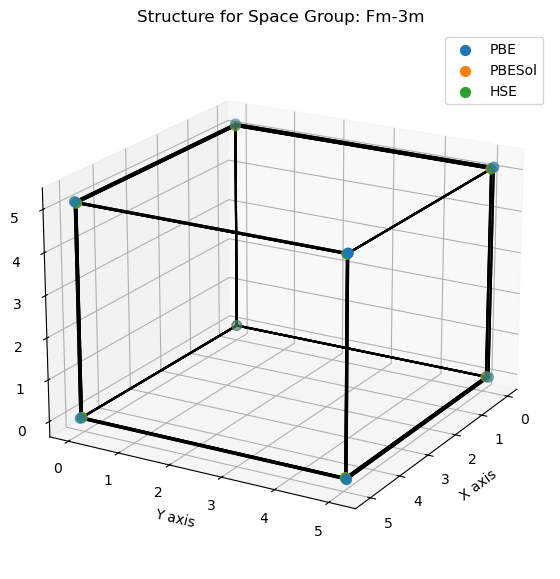

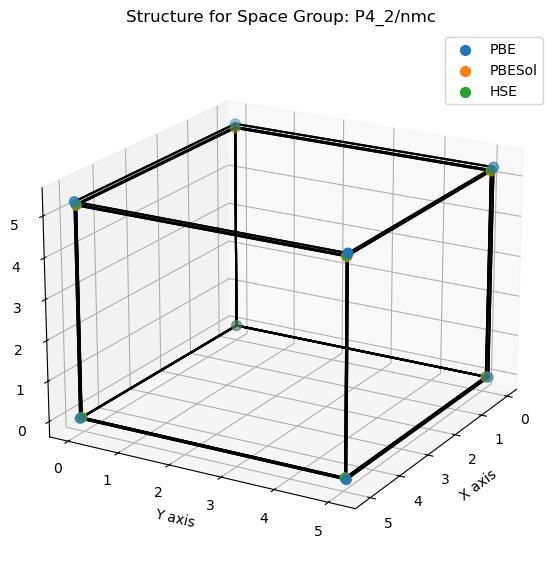

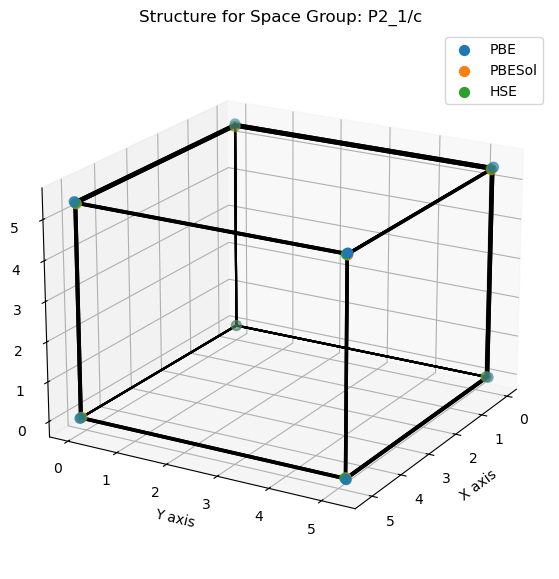

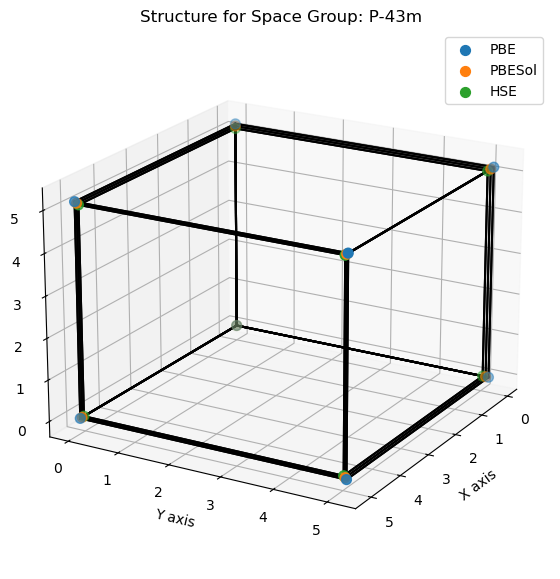

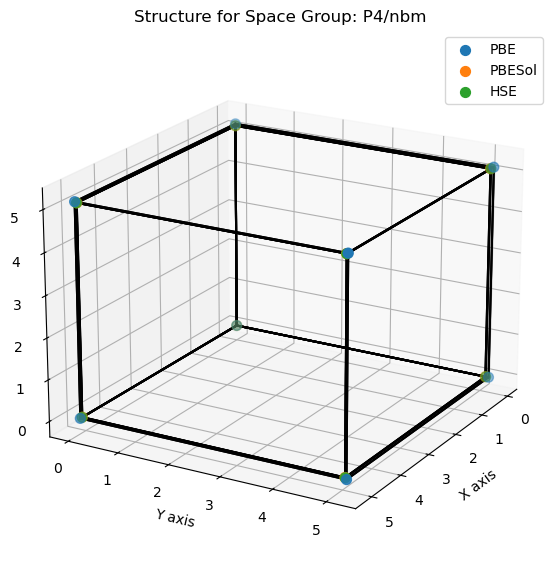

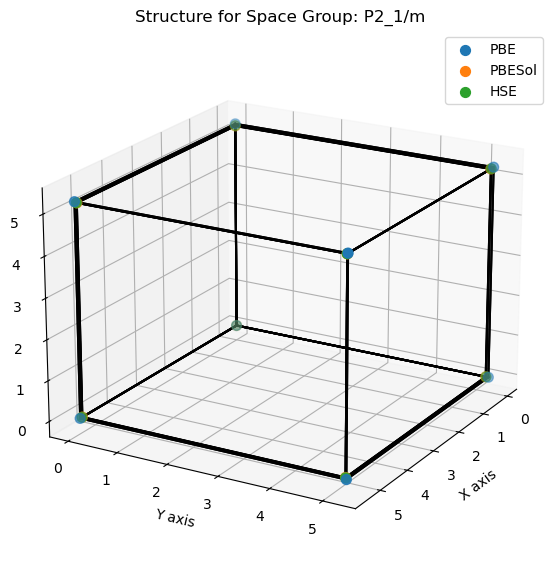

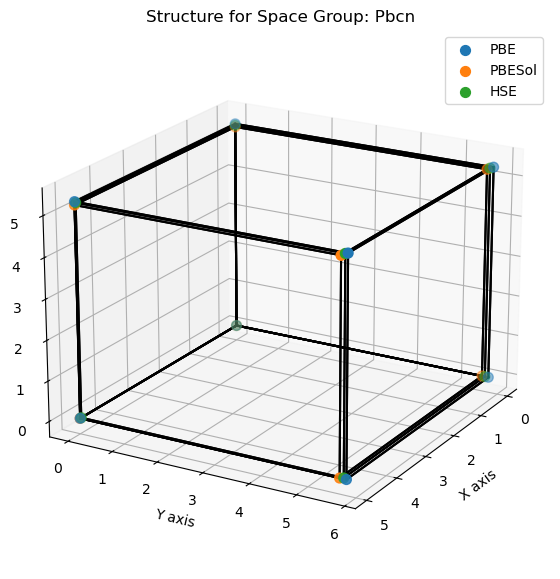

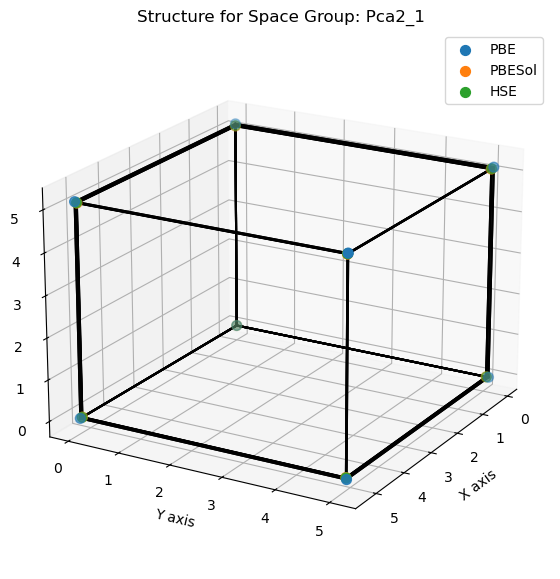

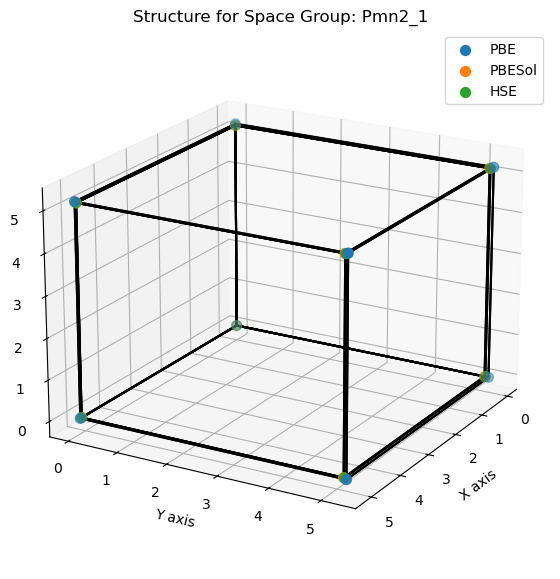

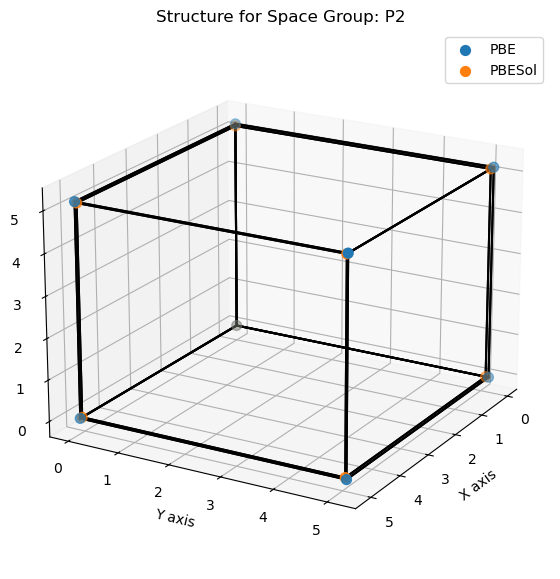

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Function to plot the cubic structure for each phase
def plot_structure(df):
    space_groups = df['Space Group'].unique()
    
    # Loop over each space group
    for space_group in space_groups:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        
        # Filter data by space group
        space_group_data = df[df['Space Group'] == space_group]
        
        # Loop through the data for each functional
        for functional in ['PBE', 'PBESol', 'HSE']:
            # Get the columns corresponding to the functional
            a_col = f"{functional} a"
            b_col = f"{functional} b"
            c_col = f"{functional} c"
            alpha_col = f"{functional} alpha"
            beta_col = f"{functional} beta"
            gamma_col = f"{functional} gamma"
            
            for _, row in space_group_data.iterrows():
                # Extract lattice constants and angles
                a, b, c = row[a_col], row[b_col], row[c_col]
                alpha, beta, gamma = row[alpha_col], row[beta_col], row[gamma_col]
                
                # Check if any value is NaN
                if any(np.isnan([a, b, c, alpha, beta, gamma])):
                    continue
                
                # Convert angles from degrees to radians
                alpha_rad = np.radians(alpha)
                beta_rad = np.radians(beta)
                gamma_rad = np.radians(gamma)
                
                # Define the transformation matrix for the lattice
                # This is a simple approach assuming orthogonal angles for cubic structures
                # If the angles are not 90 degrees, more complex handling is required.
                # Here we assume the structure is cubic for simplicity.

                # Plot the unit cell as a simple box based on lattice constants
                # Origin at (0, 0, 0)
                corners = np.array([[0, 0, 0],
                                    [a, 0, 0],
                                    [0, b, 0],
                                    [0, 0, c],
                                    [a, b, 0],
                                    [a, 0, c],
                                    [0, b, c],
                                    [a, b, c]])

                # Plot the corners of the cubic structure
                ax.scatter(corners[:, 0], corners[:, 1], corners[:, 2], label=f'{functional}', s=50)
                
                # Plot lines to form the cubic unit cell
                for i, corner1 in enumerate(corners):
                    for j, corner2 in enumerate(corners):
                        if np.sum(np.abs(corner1 - corner2)) == a or np.sum(np.abs(corner1 - corner2)) == b or np.sum(np.abs(corner1 - corner2)) == c:
                            ax.plot([corner1[0], corner2[0]], [corner1[1], corner2[1]], [corner1[2], corner2[2]], color='black')
        
        ax.set_title(f"Structure for Space Group: {space_group}")
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.view_init(elev=20, azim=30)
        
        # Show the plot
        plt.legend()
        plt.show()

# Read the CSV file
df = pd.read_csv('structure_data_grouped.csv')

# Plot the structures
plot_structure(df)


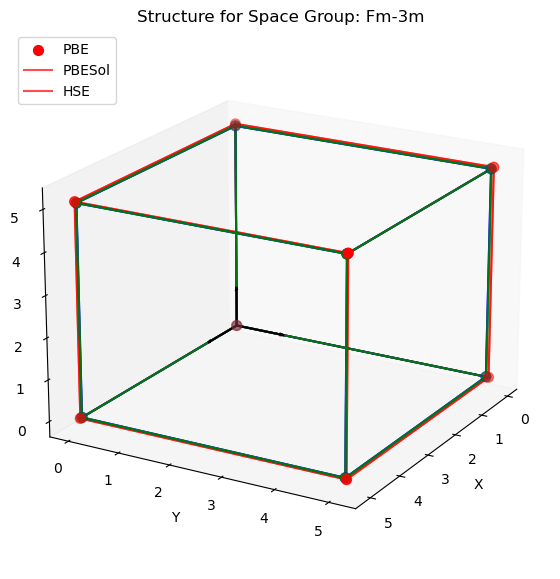

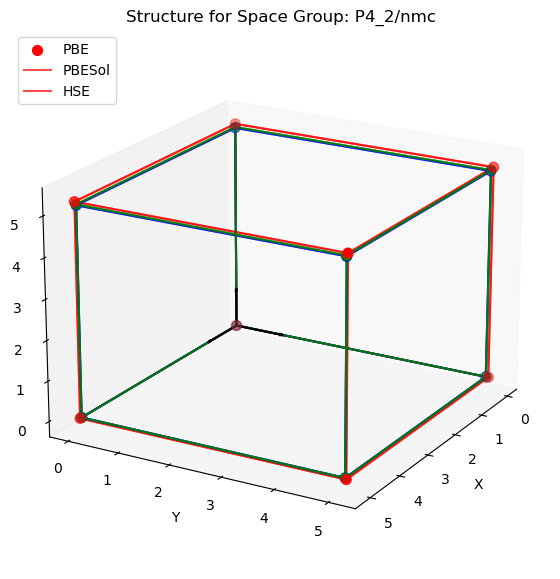

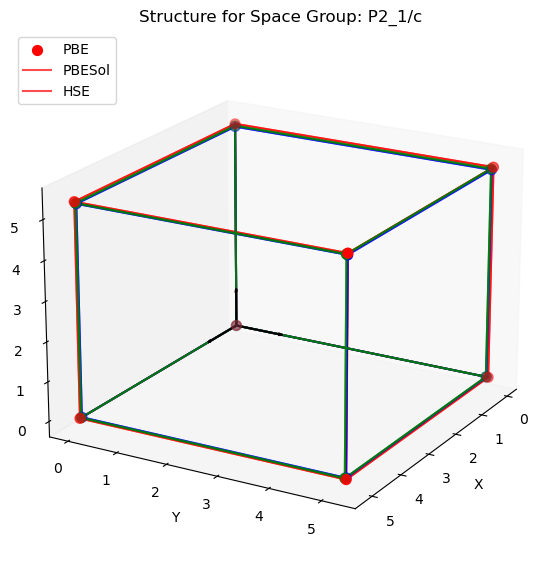

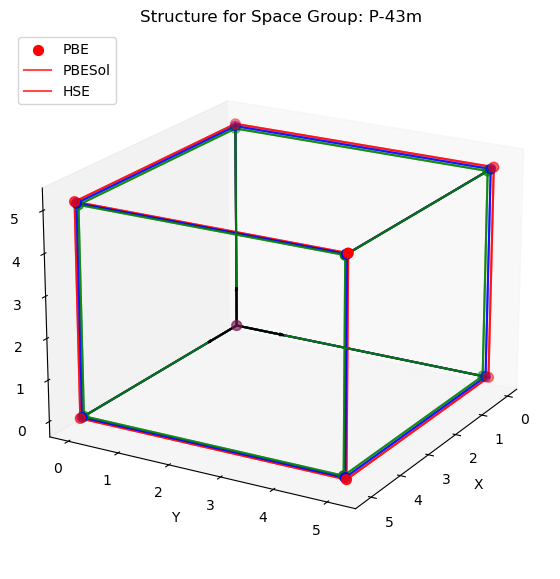

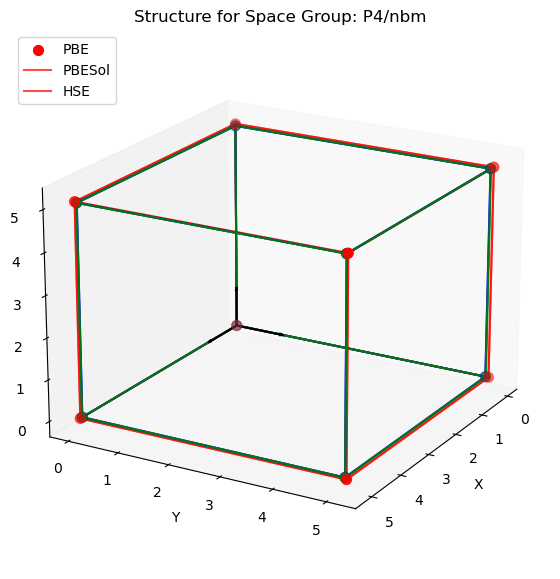

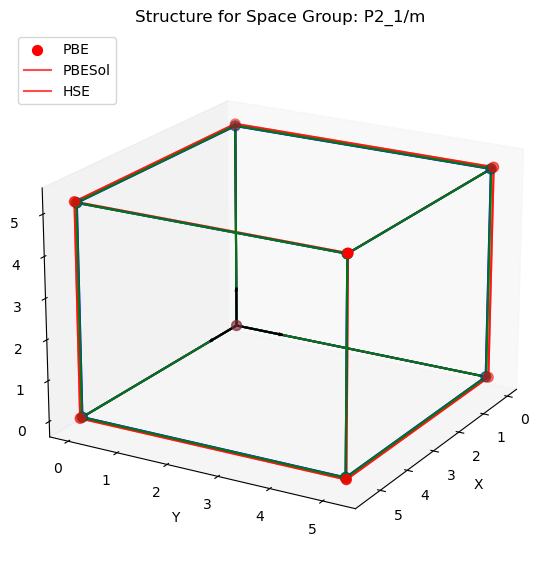

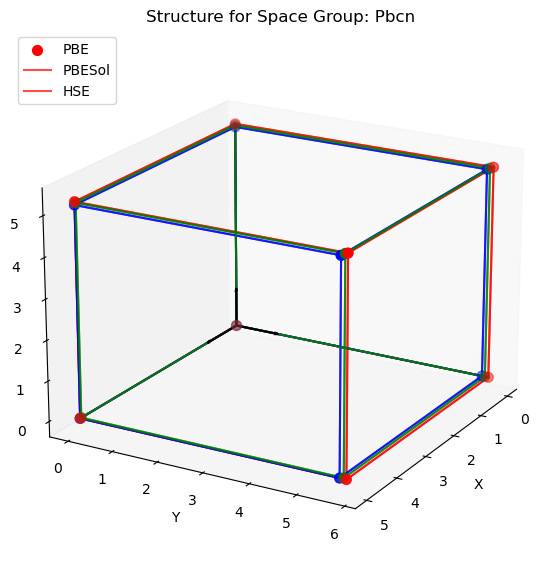

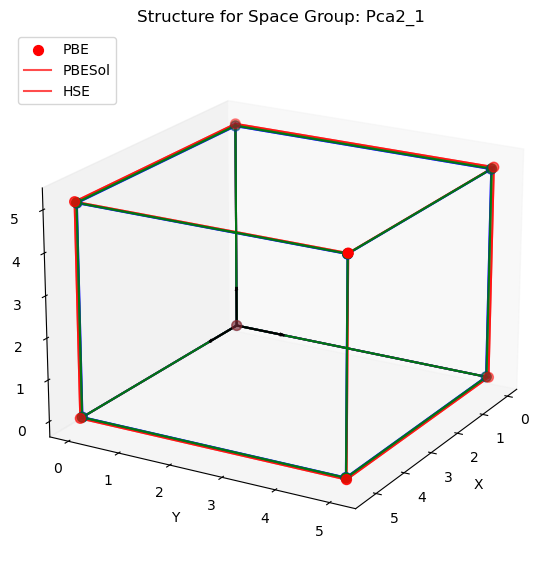

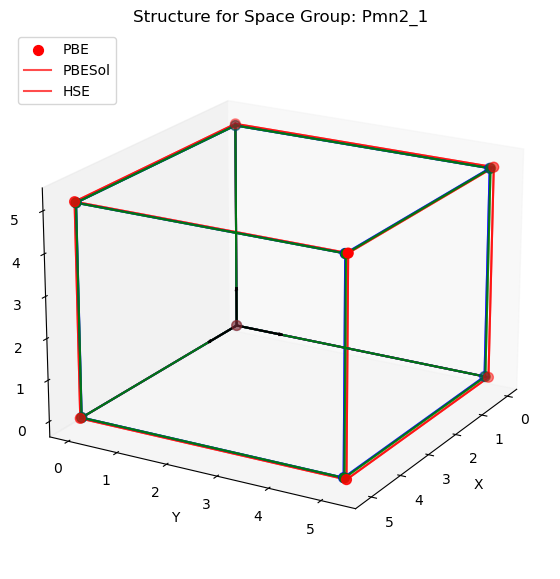

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Function to plot the cubic structure for each phase
def plot_structure(df):
    space_groups = df['Space Group'].unique()
    
    # Colors for different functionals
    functional_colors = {'PBE': 'red', 'PBESol': 'blue', 'HSE': 'green'}
    
    # Loop over each space group
    for space_group in space_groups:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        
        # Filter data by space group
        space_group_data = df[df['Space Group'] == space_group]
        
        # Loop through the data for each functional
        for functional in ['PBE', 'PBESol', 'HSE']:
            # Get the columns corresponding to the functional
            a_col = f"{functional} a"
            b_col = f"{functional} b"
            c_col = f"{functional} c"
            alpha_col = f"{functional} alpha"
            beta_col = f"{functional} beta"
            gamma_col = f"{functional} gamma"
            
            for _, row in space_group_data.iterrows():
                # Extract lattice constants and angles
                a, b, c = row[a_col], row[b_col], row[c_col]
                alpha, beta, gamma = row[alpha_col], row[beta_col], row[gamma_col]
                
                # Check if any value is NaN
                if any(np.isnan([a, b, c, alpha, beta, gamma])):
                    continue
                
                # Convert angles from degrees to radians
                alpha_rad = np.radians(alpha)
                beta_rad = np.radians(beta)
                gamma_rad = np.radians(gamma)
                
                # Define the transformation matrix for the lattice (assumes orthogonal angles)
                # For cubic structures, assuming α, β, γ are all 90 degrees.
                corners = np.array([[0, 0, 0],
                                    [a, 0, 0],
                                    [0, b, 0],
                                    [0, 0, c],
                                    [a, b, 0],
                                    [a, 0, c],
                                    [0, b, c],
                                    [a, b, c]])

                # Plot the corners of the cubic structure using the color for the functional
                ax.scatter(corners[:, 0], corners[:, 1], corners[:, 2], color=functional_colors[functional], s=50)
                
                # Plot lines to form the cubic unit cell
                for i, corner1 in enumerate(corners):
                    for j, corner2 in enumerate(corners):
                        if np.sum(np.abs(corner1 - corner2)) == a or np.sum(np.abs(corner1 - corner2)) == b or np.sum(np.abs(corner1 - corner2)) == c:
                            ax.plot([corner1[0], corner2[0]], [corner1[1], corner2[1]], [corner1[2], corner2[2]], 
                                    color=functional_colors[functional], alpha=0.7)
        
        # Set the title for the plot
        ax.set_title(f"Structure for Space Group: {space_group}")
        
        # Set axis labels
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Draw arrows indicating the positive direction of the axes
        ax.quiver(0, 0, 0, 1, 0, 0, color='black', length=1, arrow_length_ratio=0.1)
        ax.quiver(0, 0, 0, 0, 1, 0, color='black', length=1, arrow_length_ratio=0.1)
        ax.quiver(0, 0, 0, 0, 0, 1, color='black', length=1, arrow_length_ratio=0.1)
        
        # Set the viewing angle
        ax.view_init(elev=20, azim=30)
        
        # Remove the grid
        ax.grid(False)
        
        # Show the plot with a legend for each functional
        plt.legend([f'PBE', f'PBESol', f'HSE'], loc='upper left')
        plt.show()

# Read the CSV file
df = pd.read_csv('structure_data_grouped.csv')

# Plot the structures
plot_structure(df)


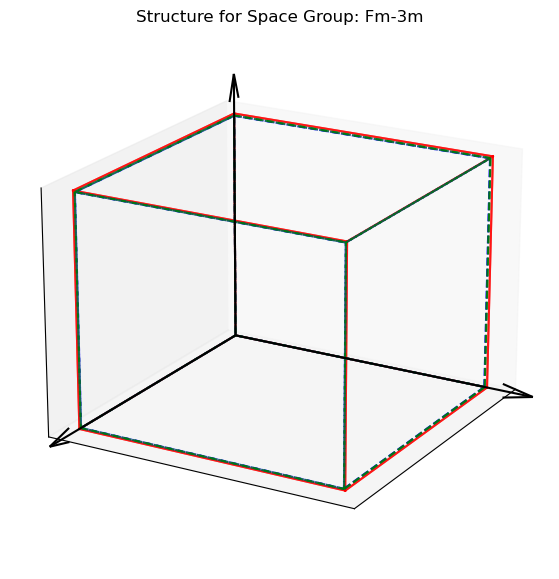

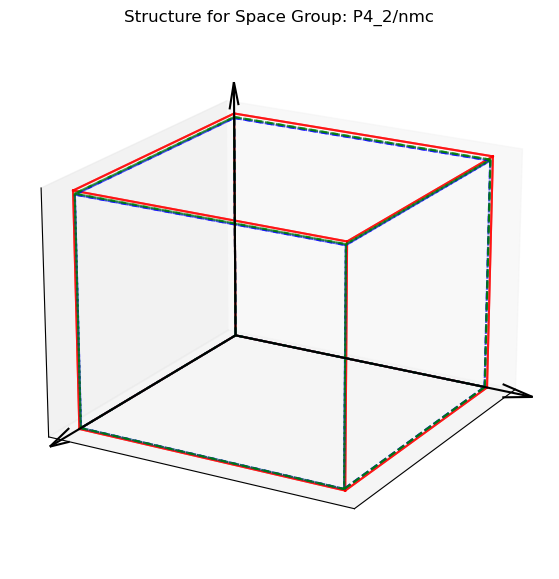

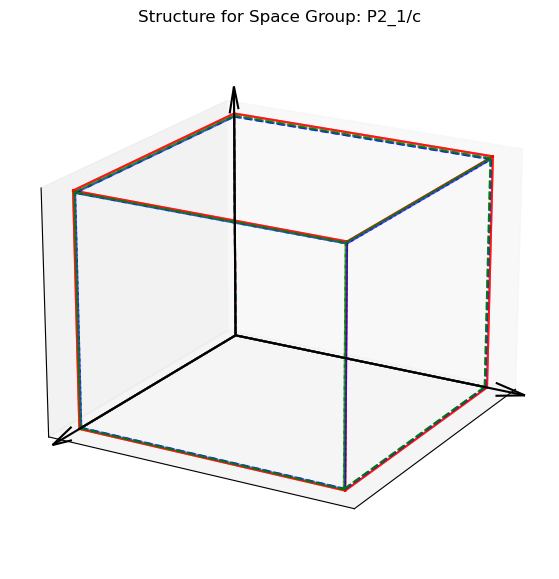

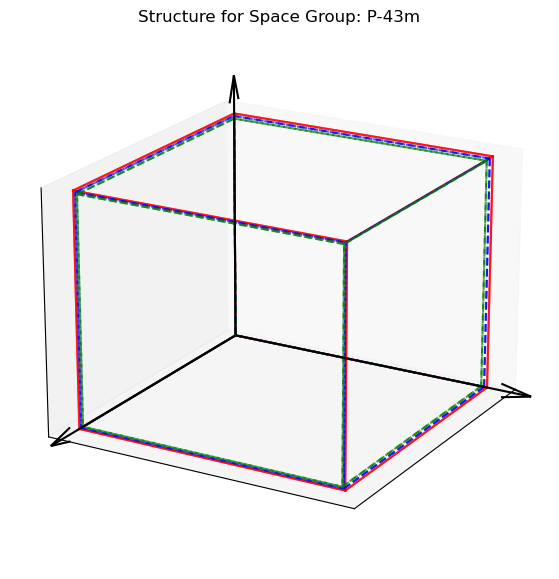

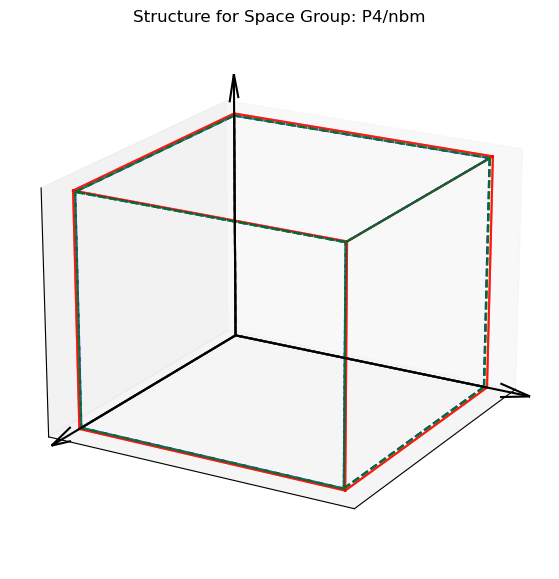

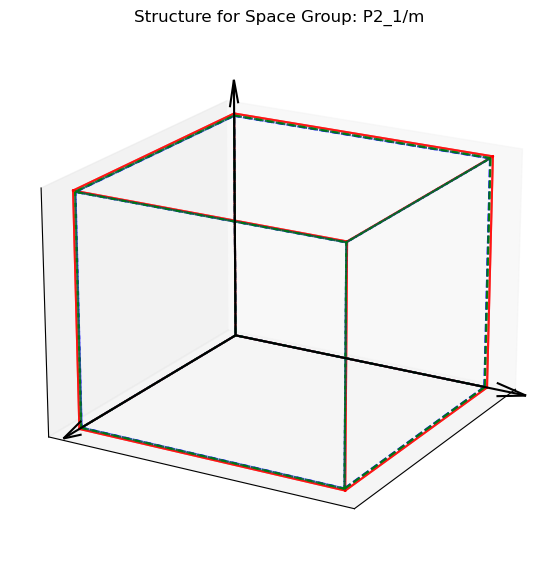

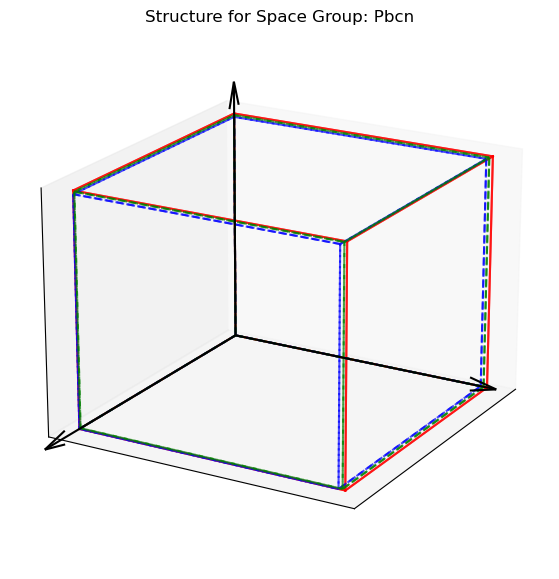

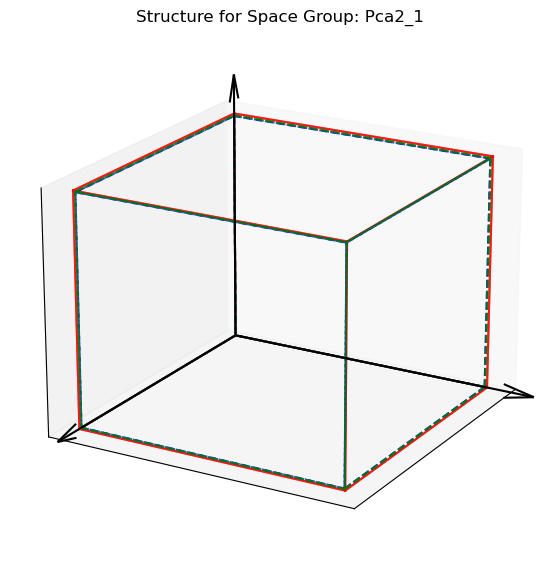

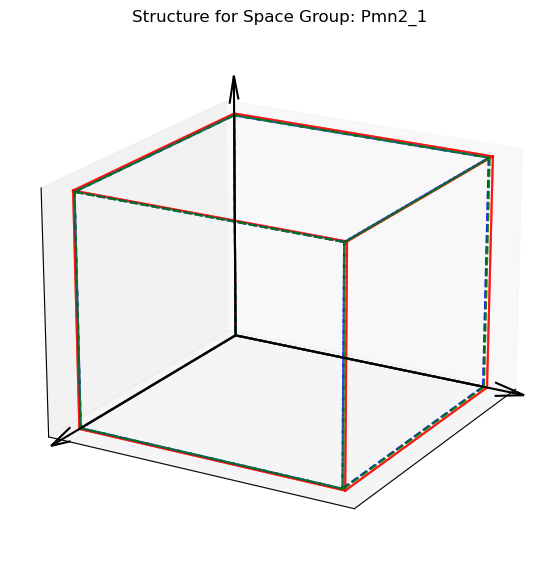

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Function to plot the cubic structure for each phase
def plot_structure(df):
    space_groups = df['Space Group'].unique()
    
    # Colors for different functionals and line styles
    functional_colors = {'PBE': 'red', 'PBESol': 'blue', 'HSE': 'green'}
    line_styles = {'PBE': '-', 'PBESol': '--', 'HSE': '--'}
    
    # Loop over each space group
    for space_group in space_groups:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        
        # Filter data by space group
        space_group_data = df[df['Space Group'] == space_group]
        
        # Loop through the data for each functional
        for functional in ['PBE', 'PBESol', 'HSE']:
            # Get the columns corresponding to the functional
            a_col = f"{functional} a"
            b_col = f"{functional} b"
            c_col = f"{functional} c"
            alpha_col = f"{functional} alpha"
            beta_col = f"{functional} beta"
            gamma_col = f"{functional} gamma"
            
            for _, row in space_group_data.iterrows():
                # Extract lattice constants and angles
                a, b, c = row[a_col], row[b_col], row[c_col]
                alpha, beta, gamma = row[alpha_col], row[beta_col], row[gamma_col]
                
                # Check if any value is NaN
                if any(np.isnan([a, b, c, alpha, beta, gamma])):
                    continue
                
                # Convert angles from degrees to radians
                alpha_rad = np.radians(alpha)
                beta_rad = np.radians(beta)
                gamma_rad = np.radians(gamma)
                
                # Define the transformation matrix for the lattice (assumes orthogonal angles)
                # For cubic structures, assuming α, β, γ are all 90 degrees.
                corners = np.array([[0, 0, 0],
                                    [a, 0, 0],
                                    [0, b, 0],
                                    [0, 0, c],
                                    [a, b, 0],
                                    [a, 0, c],
                                    [0, b, c],
                                    [a, b, c]])

                # Plot lines to form the cubic unit cell using the correct line style
                for i, corner1 in enumerate(corners):
                    for j, corner2 in enumerate(corners):
                        if np.sum(np.abs(corner1 - corner2)) == a or np.sum(np.abs(corner1 - corner2)) == b or np.sum(np.abs(corner1 - corner2)) == c:
                            ax.plot([corner1[0], corner2[0]], 
                                    [corner1[1], corner2[1]], 
                                    [corner1[2], corner2[2]], 
                                    color=functional_colors[functional], 
                                    linestyle=line_styles[functional], 
                                    alpha=0.7)
        
        # Set the title for the plot
        ax.set_title(f"Structure for Space Group: {space_group}")
        
        # Draw arrows indicating the positive direction of the axes
        ax.quiver(0, 0, 0, 1, 0, 0, color='black', length=6, arrow_length_ratio=0.1)
        ax.quiver(0, 0, 0, 0, 1, 0, color='black', length=6, arrow_length_ratio=0.1)
        ax.quiver(0, 0, 0, 0, 0, 1, color='black', length=6, arrow_length_ratio=0.1)
        
        # Set the viewing angle
        ax.view_init(elev=20, azim=30)
        
        # Remove the grid, axis labels, and ticks
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')
        
        # Show the plot with a legend for each functional
        # plt.legend([f'PBE', f'PBESol', f'HSE'], loc='upper left')
        plt.show()

# Read the CSV file
df = pd.read_csv('structure_data_grouped.csv')

# Plot the structures
plot_structure(df)


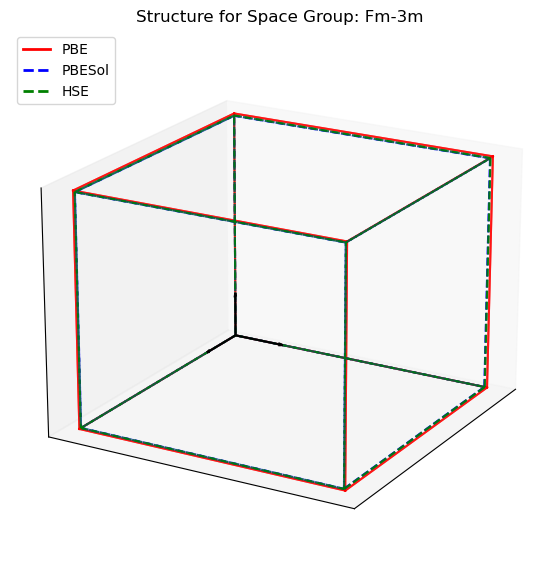

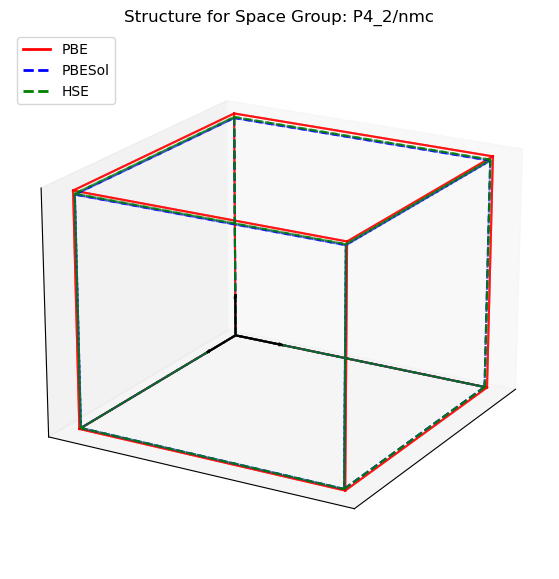

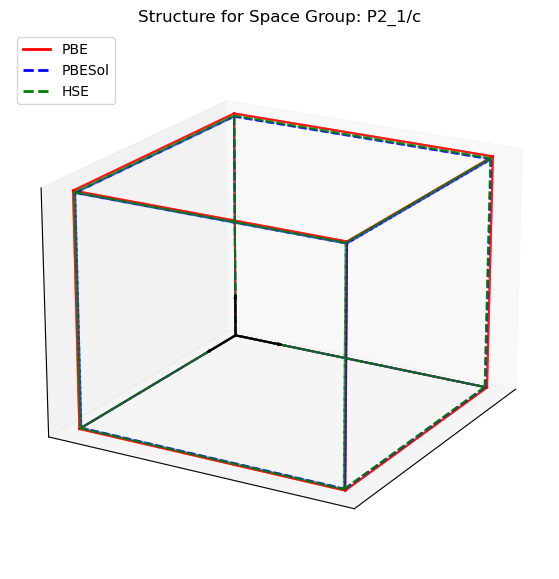

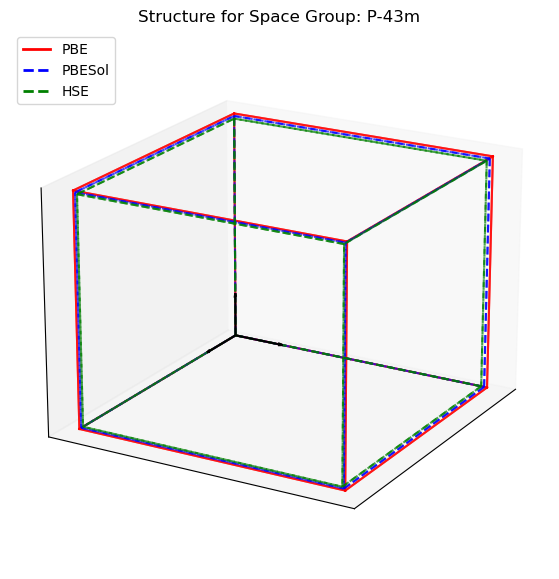

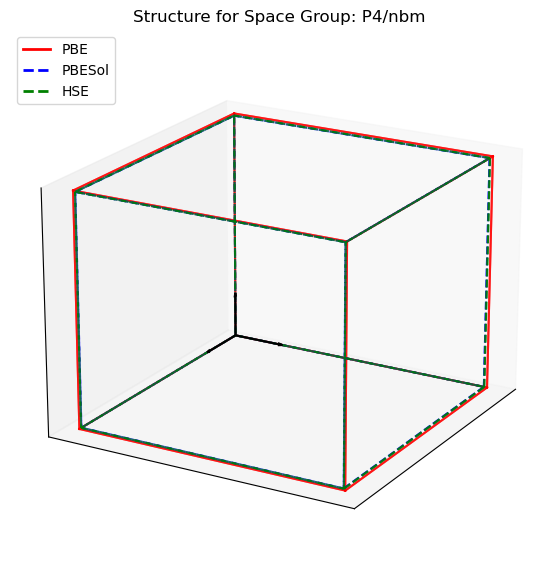

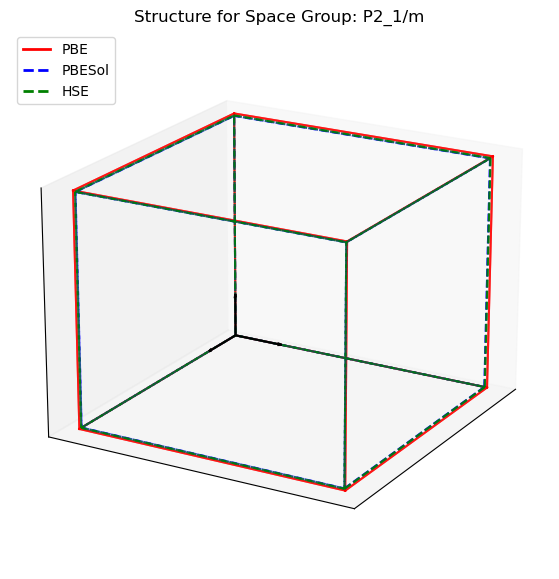

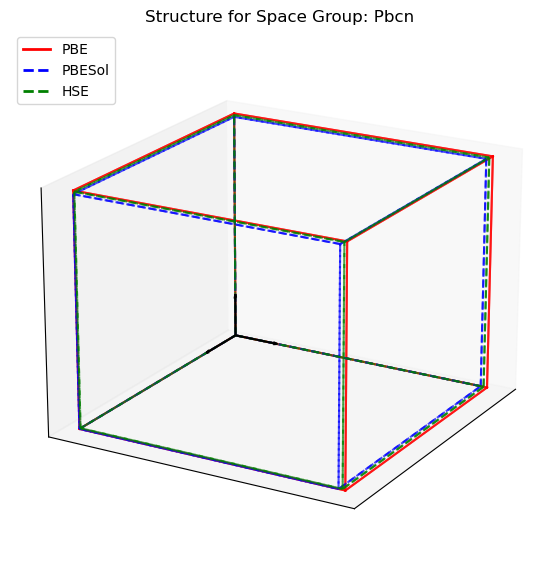

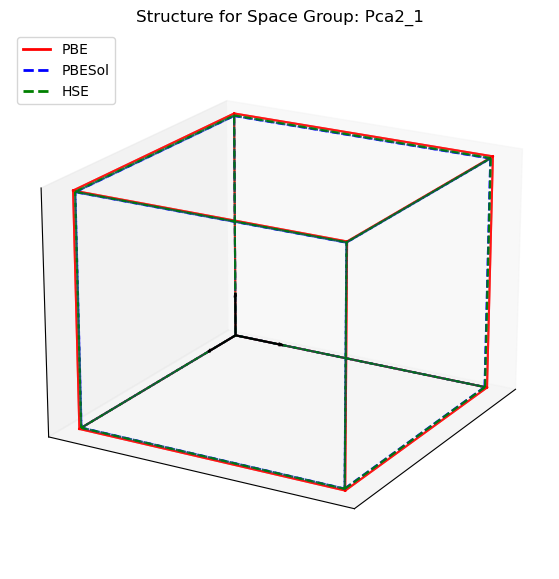

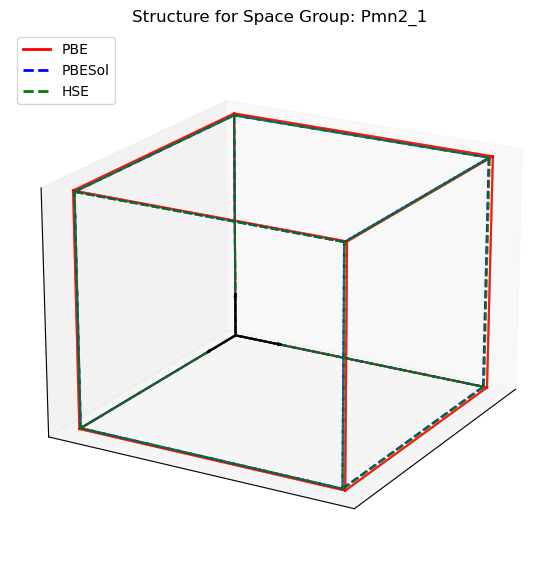

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Function to plot the cubic structure for each phase
def plot_structure(df):
    space_groups = df['Space Group'].unique()
    
    # Colors for different functionals and line styles
    functional_colors = {'PBE': 'red', 'PBESol': 'blue', 'HSE': 'green'}
    line_styles = {'PBE': '-', 'PBESol': '--', 'HSE': '--'}
    
    # Loop over each space group
    for space_group in space_groups:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')  # No frame_on for 3D axes
        
        # Remove the frame (border) by setting the spines to invisible
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Filter data by space group
        space_group_data = df[df['Space Group'] == space_group]
        
        # Loop through the data for each functional
        for functional in ['PBE', 'PBESol', 'HSE']:
            # Get the columns corresponding to the functional
            a_col = f"{functional} a"
            b_col = f"{functional} b"
            c_col = f"{functional} c"
            alpha_col = f"{functional} alpha"
            beta_col = f"{functional} beta"
            gamma_col = f"{functional} gamma"
            
            for _, row in space_group_data.iterrows():
                # Extract lattice constants and angles
                a, b, c = row[a_col], row[b_col], row[c_col]
                alpha, beta, gamma = row[alpha_col], row[beta_col], row[gamma_col]
                
                # Check if any value is NaN
                if any(np.isnan([a, b, c, alpha, beta, gamma])):
                    continue
                
                # # Convert angles from degrees to radians
                # alpha_rad = np.radians(alpha)
                # beta_rad = np.radians(beta)
                # gamma_rad = np.radians(gamma)
                
                # Define the transformation matrix for the lattice (assumes orthogonal angles)
                # For cubic structures, assuming α, β, γ are all 90 degrees.
                corners = np.array([[0, 0, 0],
                                    [a, 0, 0],
                                    [0, b, 0],
                                    [0, 0, c],
                                    [a, b, 0],
                                    [a, 0, c],
                                    [0, b, c],
                                    [a, b, c]])

                # Plot lines to form the cubic unit cell using the correct line style
                for i, corner1 in enumerate(corners):
                    for j, corner2 in enumerate(corners):
                        if np.sum(np.abs(corner1 - corner2)) == a or np.sum(np.abs(corner1 - corner2)) == b or np.sum(np.abs(corner1 - corner2)) == c:
                            ax.plot([corner1[0], corner2[0]], 
                                    [corner1[1], corner2[1]], 
                                    [corner1[2], corner2[2]], 
                                    color=functional_colors[functional], 
                                    linestyle=line_styles[functional], 
                                    alpha=0.7)
        
        # Set the title for the plot
        ax.set_title(f"Structure for Space Group: {space_group}")
        
        # Draw arrows indicating the positive direction of the axes
        ax.quiver(0, 0, 0, 1, 0, 0, color='black', length=1, arrow_length_ratio=0.1)
        ax.quiver(0, 0, 0, 0, 1, 0, color='black', length=1, arrow_length_ratio=0.1)
        ax.quiver(0, 0, 0, 0, 0, 1, color='black', length=1, arrow_length_ratio=0.1)
        
        # Set the viewing angle
        ax.view_init(elev=20, azim=30)
        
        # Remove the grid, axis labels, and ticks
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')
        
        # Manually create a legend with matching colors and line styles
        handles = []
        for functional, color in functional_colors.items():
            line = plt.Line2D([0], [0], color=color, linestyle=line_styles[functional], lw=2)
            handles.append(line)
        
        # Show the plot with the updated legend
        ax.legend(handles, ['PBE', 'PBESol', 'HSE'], loc='upper left')
        
        # Set the figure background to transparent
        fig.patch.set_facecolor('none')
        
        plt.show()

# Read the CSV file
df = pd.read_csv('structure_data_grouped.csv')

# Plot the structures
plot_structure(df)


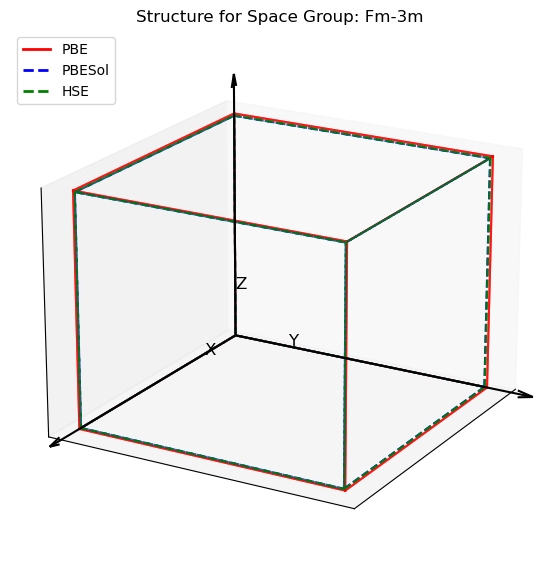

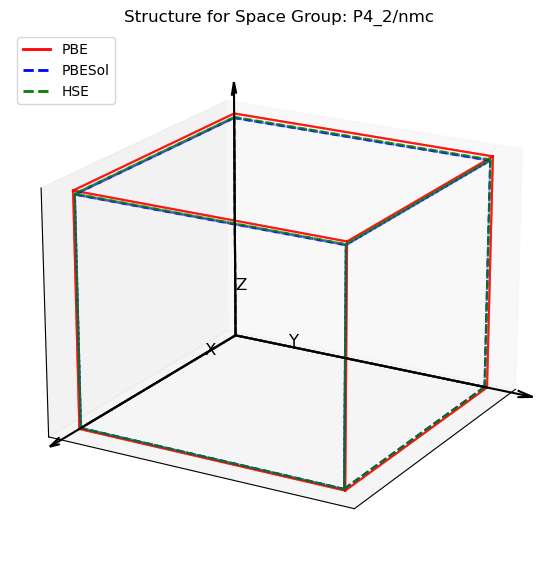

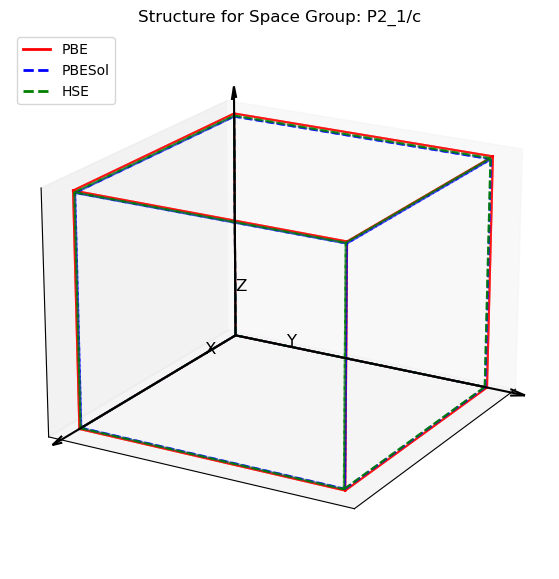

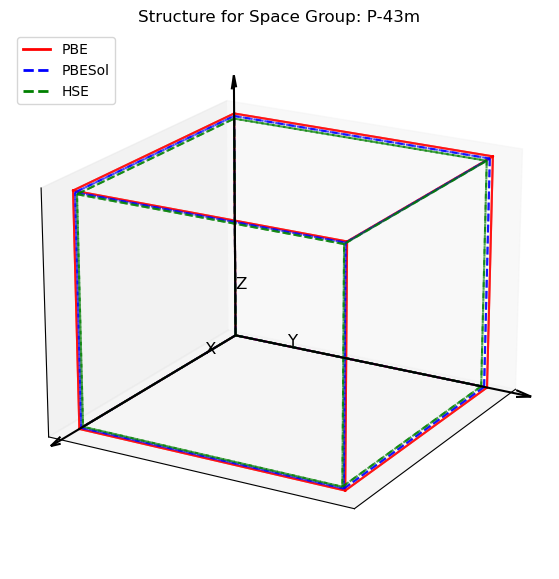

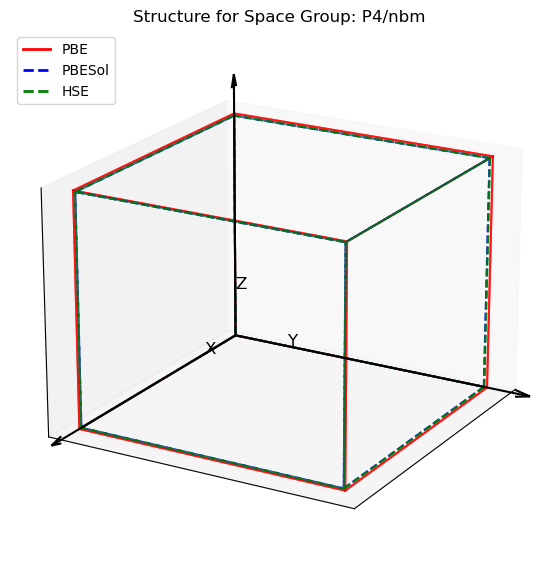

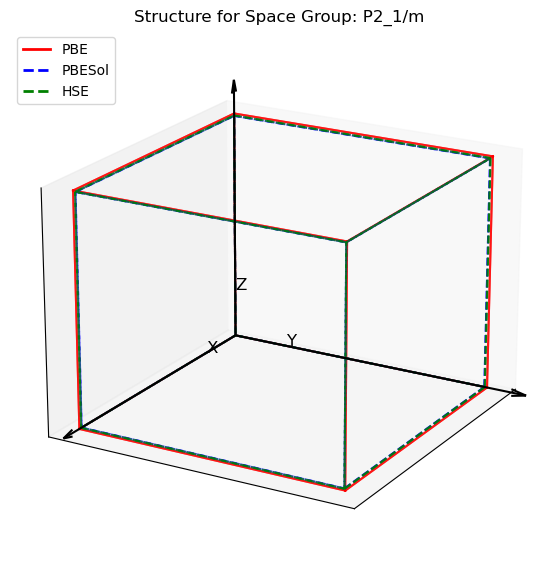

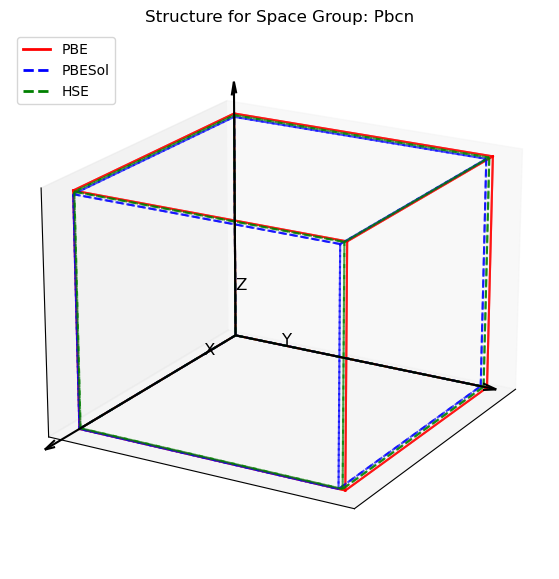

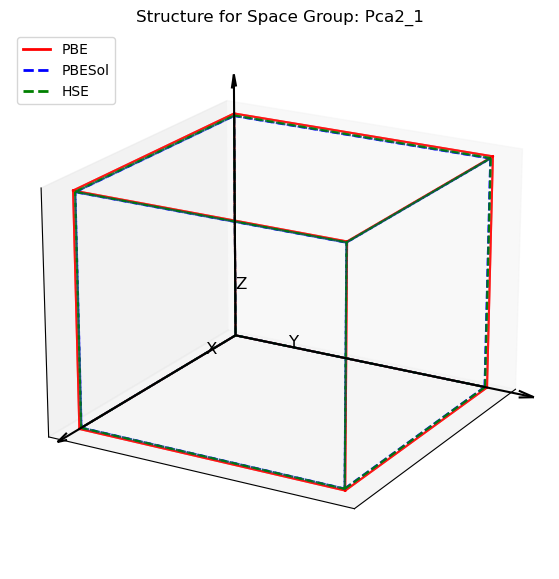

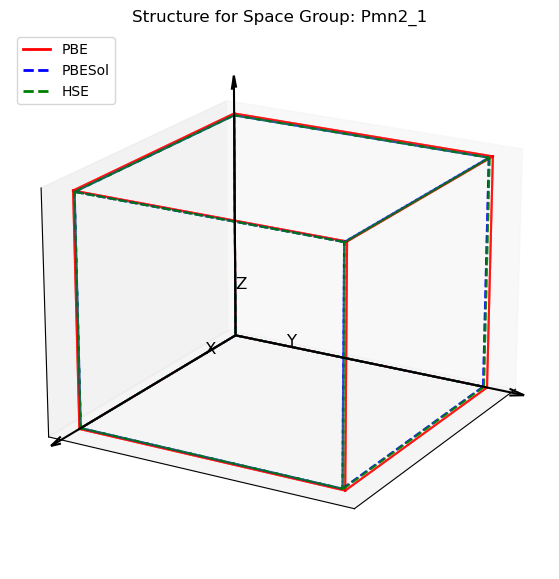

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Function to plot the cubic structure for each phase
def plot_structure(df):
    space_groups = df['Space Group'].unique()
    
    # Colors for different functionals and line styles
    functional_colors = {'PBE': 'red', 'PBESol': 'blue', 'HSE': 'green'}
    line_styles = {'PBE': '-', 'PBESol': '--', 'HSE': '--'}
    
    # Loop over each space group
    for space_group in space_groups:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')  # No frame_on for 3D axes
        
        # Remove the frame (border) by setting the spines to invisible
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Filter data by space group
        space_group_data = df[df['Space Group'] == space_group]
        
        # Loop through the data for each functional
        for functional in ['PBE', 'PBESol', 'HSE']:
            # Get the columns corresponding to the functional
            a_col = f"{functional} a"
            b_col = f"{functional} b"
            c_col = f"{functional} c"
            alpha_col = f"{functional} alpha"
            beta_col = f"{functional} beta"
            gamma_col = f"{functional} gamma"
            
            for _, row in space_group_data.iterrows():
                # Extract lattice constants and angles
                a, b, c = row[a_col], row[b_col], row[c_col]
                alpha, beta, gamma = row[alpha_col], row[beta_col], row[gamma_col]
                
                # Check if any value is NaN
                if any(np.isnan([a, b, c, alpha, beta, gamma])):
                    continue
                
                # Convert angles from degrees to radians
                alpha_rad = np.radians(alpha)
                beta_rad = np.radians(beta)
                gamma_rad = np.radians(gamma)
                
                # Define the transformation matrix for the lattice (assumes orthogonal angles)
                # For cubic structures, assuming α, β, γ are all 90 degrees.
                corners = np.array([[0, 0, 0],
                                    [a, 0, 0],
                                    [0, b, 0],
                                    [0, 0, c],
                                    [a, b, 0],
                                    [a, 0, c],
                                    [0, b, c],
                                    [a, b, c]])
                                    

                # Plot lines to form the cubic unit cell using the correct line style
                for i, corner1 in enumerate(corners):
                    for j, corner2 in enumerate(corners):
                        if np.sum(np.abs(corner1 - corner2)) == a or np.sum(np.abs(corner1 - corner2)) == b or np.sum(np.abs(corner1 - corner2)) == c:
                            ax.plot([corner1[0], corner2[0]], 
                                    [corner1[1], corner2[1]], 
                                    [corner1[2], corner2[2]], 
                                    color=functional_colors[functional], 
                                    linestyle=line_styles[functional], 
                                    alpha=0.7)
        
        # Set the title for the plot
        ax.set_title(f"Structure for Space Group: {space_group}")
        
        # Draw orthogonal arrows indicating the positive direction of the axes
        ax.quiver(0, 0, 0, 1, 0, 0, color='black', length=6, arrow_length_ratio=0.05)
        ax.quiver(0, 0, 0, 0, 1, 0, color='black', length=6, arrow_length_ratio=0.05)
        ax.quiver(0, 0, 0, 0, 0, 1, color='black', length=6, arrow_length_ratio=0.05)

        # Label the axes
        ax.text(1.1, 0, 0, 'X', color='black', fontsize=12)
        ax.text(0, 1.1, 0, 'Y', color='black', fontsize=12)
        ax.text(0, 0, 1.1, 'Z', color='black', fontsize=12)
        
        # Set the viewing angle
        ax.view_init(elev=20, azim=30)
        
        # Remove the grid, axis labels, and ticks
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')
        
        # Manually create a legend with matching colors and line styles
        handles = []
        for functional, color in functional_colors.items():
            line = plt.Line2D([0], [0], color=color, linestyle=line_styles[functional], lw=2)
            handles.append(line)
        
        # Show the plot with the updated legend
        ax.legend(handles, ['PBE', 'PBESol', 'HSE'], loc='upper left')
        
        # # Set the figure background to transparent
        # fig.patch.set_facecolor('none')
        
        plt.show()

# Read the CSV file
df = pd.read_csv('structure_data_grouped.csv')

# Plot the structures
plot_structure(df)


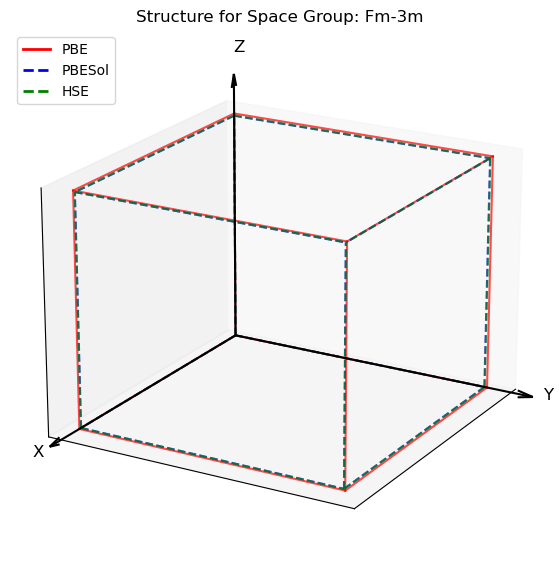

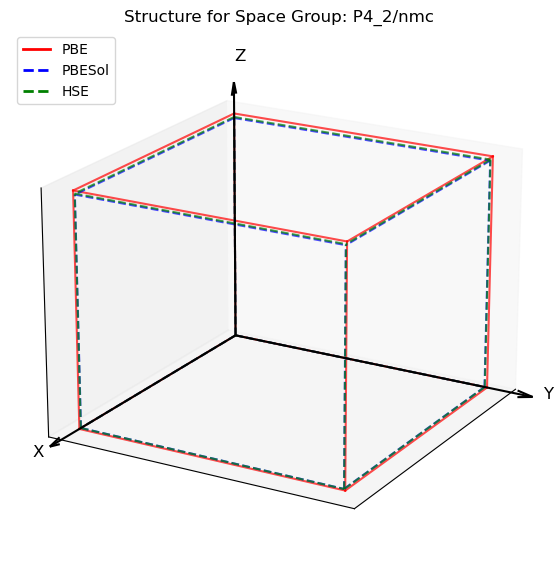

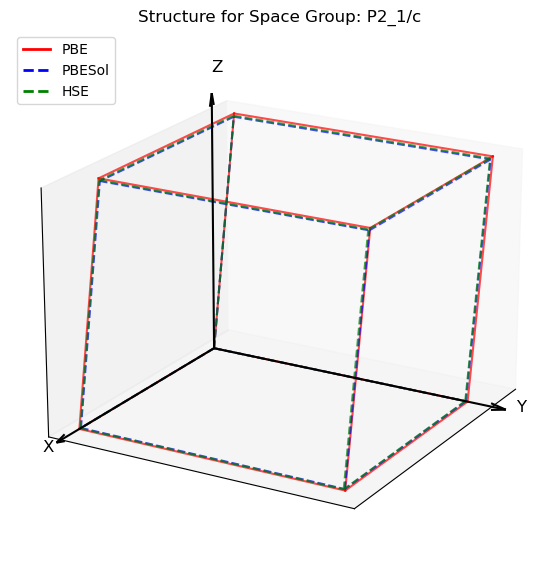

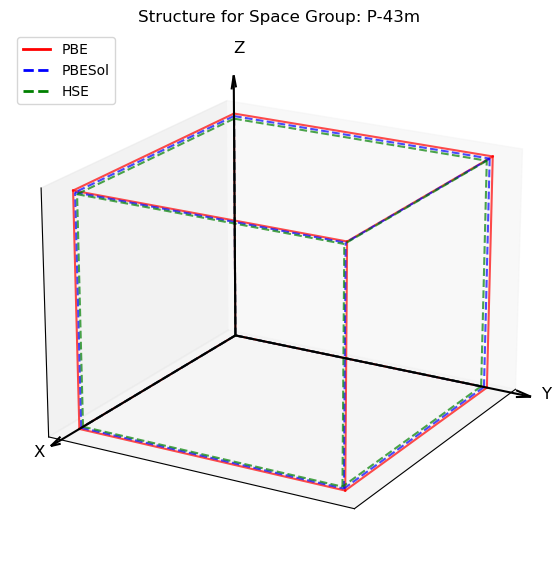

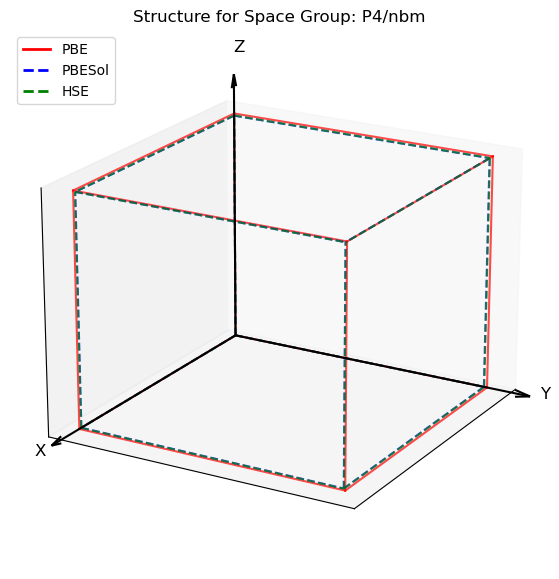

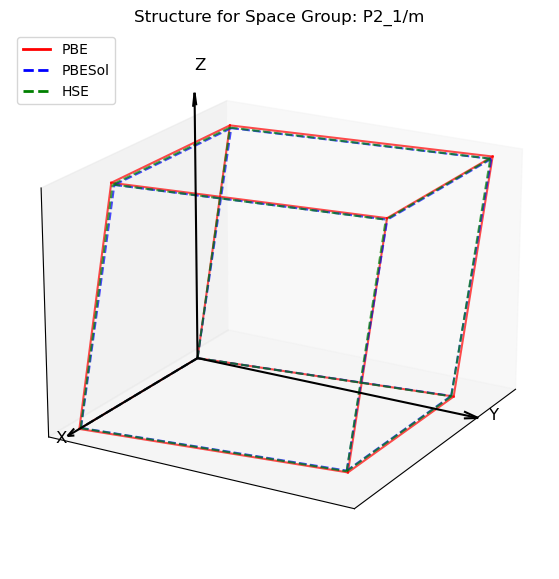

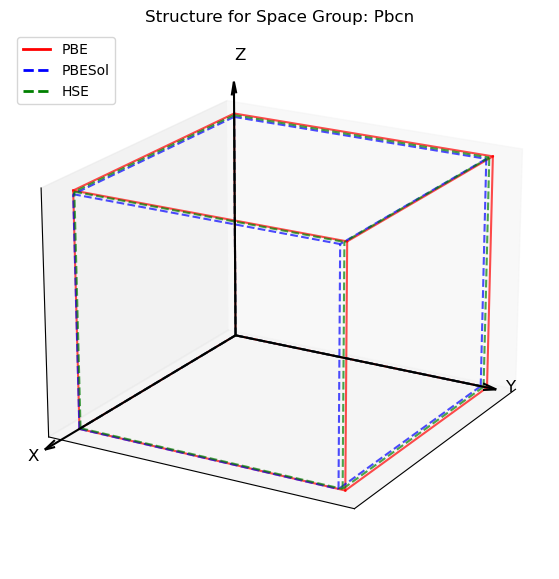

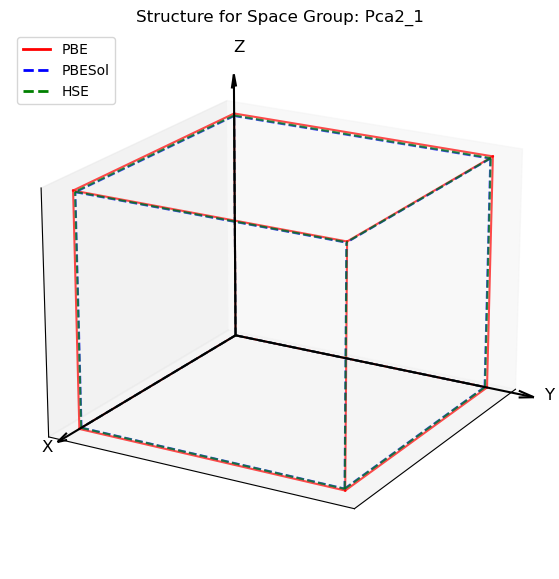

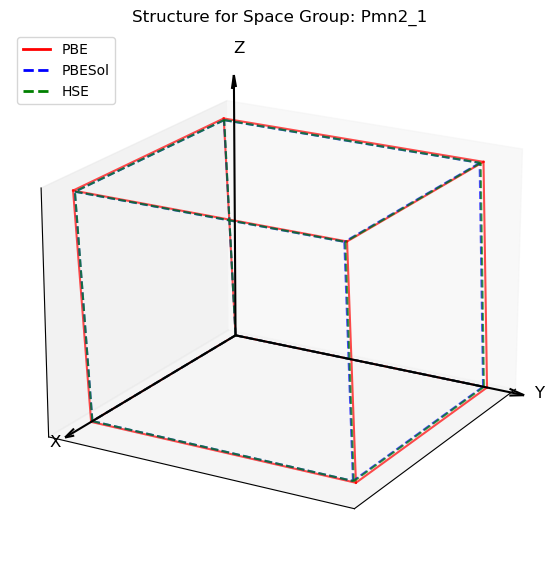

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Function to plot the cubic structure for each phase
def plot_structure(df):
    space_groups = df['Space Group'].unique()
    
    # Colors for different functionals and line styles
    functional_colors = {'PBE': 'red', 'PBESol': 'blue', 'HSE': 'green'}
    line_styles = {'PBE': '-', 'PBESol': '--', 'HSE': '--'}
    
    # Loop over each space group
    for space_group in space_groups:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')  # No frame_on for 3D axes
        
        # Remove the frame (border) by setting the spines to invisible
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Filter data by space group
        space_group_data = df[df['Space Group'] == space_group]
        
        # Loop through the data for each functional
        for functional in ['PBE', 'PBESol', 'HSE']:
            # Get the columns corresponding to the functional
            a_col = f"{functional} a"
            b_col = f"{functional} b"
            c_col = f"{functional} c"
            alpha_col = f"{functional} alpha"
            beta_col = f"{functional} beta"
            gamma_col = f"{functional} gamma"
            
            for _, row in space_group_data.iterrows():
                # Extract lattice constants and angles
                a, b, c = row[a_col], row[b_col], row[c_col]
                alpha, beta, gamma = row[alpha_col], row[beta_col], row[gamma_col]
                
                # Check if any value is NaN
                if any(np.isnan([a, b, c, alpha, beta, gamma])):
                    continue
                
                # Convert angles from degrees to radians
                alpha_rad = np.radians(alpha)
                beta_rad = np.radians(beta)
                gamma_rad = np.radians(gamma)
                
                # Define the transformation matrix for the lattice
                # Using the full formula for non-orthogonal lattice
                A = np.array([
                    [a, 0, 0],
                    [b * np.cos(gamma_rad), b * np.sin(gamma_rad), 0],
                    [c * np.cos(beta_rad), 
                     c * (np.cos(alpha_rad) - np.cos(beta_rad) * np.cos(gamma_rad)) / np.sin(gamma_rad), 
                     c * np.sqrt(1 - np.cos(beta_rad)**2 - (np.cos(alpha_rad) - np.cos(beta_rad) * np.cos(gamma_rad))**2 / np.sin(gamma_rad)**2)]
                ])
                
                # Generate the 8 corners of the unit cell based on the lattice matrix
                corners = []
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            # Use the lattice matrix A to generate the points
                            point = i * A[0] + j * A[1] + k * A[2]
                            corners.append(point)
                
                corners = np.array(corners)


                lines = [
                    [corners[0], corners[1]],  # (0,0,0) -> (a,0,0)
                    [corners[0], corners[2]],  # (0,0,0) -> (0,b,0)
                    [corners[0], corners[4]],  # (0,0,0) -> (0,0,c)
                    [corners[1], corners[3]],  # (a,0,0) -> (a,b,0)
                    [corners[1], corners[5]],  # (a,0,0) -> (a,0,c)
                    [corners[2], corners[3]],  # (0,b,0) -> (a,b,0)
                    [corners[2], corners[6]],  # (0,b,0) -> (0,b,c)
                    [corners[4], corners[5]],  # (0,0,c) -> (a,0,c)
                    [corners[4], corners[6]],  # (0,0,c) -> (0,b,c)
                    [corners[5], corners[7]],  # (a,0,c) -> (a,b,c)
                    [corners[6], corners[7]],  # (0,b,c) -> (a,b,c)
                    [corners[3], corners[7]]   # (a,b,0) -> (a,b,c)
                ]

                for line in lines:
                    ax.plot([line[0][0], line[1][0]], 
                            [line[0][1], line[1][1]], 
                            [line[0][2], line[1][2]], 
                            color=functional_colors[functional], 
                            linestyle=line_styles[functional], 
                            alpha=0.7)


                # corners = np.array([[0, 0, 0],
                #                     [a, 0, 0],
                #                     [0, b, 0],
                #                     [0, 0, c],
                #                     [a, b, 0],
                #                     [a, 0, c],
                #                     [0, b, c],
                #                     [a, b, c]])


                # Plot lines to form the cubic unit cell using the correct line style
                # for i, corner1 in enumerate(corners):
                #     for j, corner2 in enumerate(corners):
                #         # Only draw a line if the difference in coordinates matches a, b, or c
                #         if np.sum(np.abs(corner1 - corner2)) == a or np.sum(np.abs(corner1 - corner2)) == b or np.sum(np.abs(corner1 - corner2)) == c:
                #             ax.plot([corner1[0], corner2[0]], 
                #                     [corner1[1], corner2[1]], 
                #                     [corner1[2], corner2[2]], 
                #                     color=functional_colors[functional], 
                #                     linestyle=line_styles[functional], 
                #                     alpha=0.7)
        
        # Set the title for the plot
        ax.set_title(f"Structure for Space Group: {space_group}")
        
        # Draw orthogonal arrows indicating the positive direction of the axes
        ax.quiver(0, 0, 0, 1, 0, 0, color='black', length=6, arrow_length_ratio=0.05)
        ax.quiver(0, 0, 0, 0, 1, 0, color='black', length=6, arrow_length_ratio=0.05)
        ax.quiver(0, 0, 0, 0, 0, 1, color='black', length=6, arrow_length_ratio=0.05)

        # Label the axes
        ax.text(6.5, 0, 0, 'X', color='black', fontsize=12)
        ax.text(0, 6.2, 0, 'Y', color='black', fontsize=12)
        ax.text(0, 0, 6.5, 'Z', color='black', fontsize=12)
        
        # Set the viewing angle
        ax.view_init(elev=20, azim=30)
        
        # Remove the grid, axis labels, and ticks
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')
        
        # Manually create a legend with matching colors and line styles
        handles = []
        for functional, color in functional_colors.items():
            line = plt.Line2D([0], [0], color=color, linestyle=line_styles[functional], lw=2)
            handles.append(line)
        
        # Show the plot with the updated legend
        ax.legend(handles, ['PBE', 'PBESol', 'HSE'], loc='upper left')
        
        # Show the plot
        plt.show()

# Read the CSV file
df = pd.read_csv('structure_data_grouped.csv')

# Plot the structures
plot_structure(df)
